In [ ]:
import pandas as pd
import atomica.ui as au
import matplotlib.pyplot as plt
import numpy as np

# Data and Databooks

Project data for an application is specified in a 'databook'. This is an Excel file that contains

- A listing of which populations a simulation will have
- A specification of which transfers are present
- Population and time specific values for characteristics, parameters, transfers, and interactions

`ProjectData` is a Python object containing the data, and it has methods to convert to and from the databook spreadsheet.

In [ ]:
F = au.ProjectFramework(au.LIBRARY_PATH + "tb_framework.xlsx")
data = au.ProjectData.from_spreadsheet(au.LIBRARY_PATH + "tb_databook.xlsx",F)

The `ProjectData` object contains a number of attributes
- `pops` is an odict storing populations and their full names. In the future, it may also store other attributes such as species
- `tvec` stores the default time array associated with the data (users can override this on a per-table basis)
- `transfers` and `interactions` store pairwise time series linking populations
- `tdve` stores a dict of `TimeDependentValueEntry` tables for characteristics and parameters
- `tdve_pages` stores a dict assigning TDVE tables to worksheets

There are three basic elements to the databook

1. The population table
2. `TimeDependentConnection` tables which are used for transfers and interactions. These have a 'to' and a 'from' population
3. `TimeDependentValueEntry` tables which are used for characteristics and parameters

## `TimeSeries` objects

Time-varying data is backed by the `TimeSeries` object defined in `structure.py`. This object stores sparse time-varying data, together with an assumption. This allows it to keep track of both assumption and time-varying values entered in a databook. It has a few key properties

In [ ]:
ts = au.TimeSeries(t=[2014,2015],vals=[1,2])

A TimeSeries has `t` and `vals` attributes that store the time varying data

In [ ]:
ts.t

In [ ]:
ts.vals

The values can be modified using the `insert` and `remove` methods. These preserve the order of the times. Notice that the `remove` method removes data based on the time value rather than the index.

In [ ]:
ts.insert(2016,3)
ts.remove(2015)
ts.vals

A `TimeSeries` object also has an interpolate method to query its value at arbitrary times. It uses the same interpolation as for parameters, with constant extrapolation

In [ ]:
t = np.arange(2013,2018,0.2)
plt.plot(t,ts.interpolate(t))

One of the special features of the `TimeSeries` object that caters for databook entry is the fact that it can independently store the constant assumption value. This is set by inserting a value with no time associated with it

In [ ]:
ts2 = au.TimeSeries()
ts2.insert(None,2)
ts2.assumption

Since the data for a `TimeSeries` could be in `assumption` or in `vals`, the method `get_arrays` allows you to get time and value arrays for the content of the `TimeSeries`

In [ ]:
t,v = ts.get_arrays()
print(t)
print(v)

t,v = ts2.get_arrays()
print(t)
print(v)

However, the most common usage for the `TimeSeries` is to turn sparse data into full interpolated arrays. The `interpolate` method automatically manages the assumption and the time dependent values, so that you don't have to do this yourself:

In [ ]:
t = np.arange(2013,2018,0.2)
plt.plot(t,ts.interpolate(t),label='Time varying')
plt.plot(t,ts2.interpolate(t),label='Assumption')
plt.legend()

The `TimeSeries` object also has a `units` property that lets it store the units of the quantity entered in the databook.

<div class="alert alert-info">
In general, whenever the databook has a time-dependent values row with an assumption and some year-specific data, the corresponding object used to store the data on that row is a `TimeSeries`

### Population table

The population table is very basic:

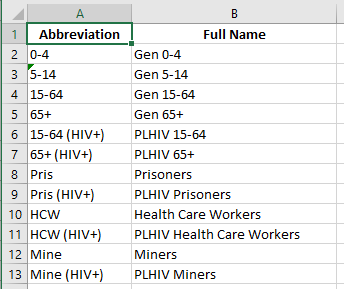

in the future, there will probably be more columns - for example, to separate human and mosquito populations (these would need to be validated against tags specified in the Framework)

### TimeDependentConnections

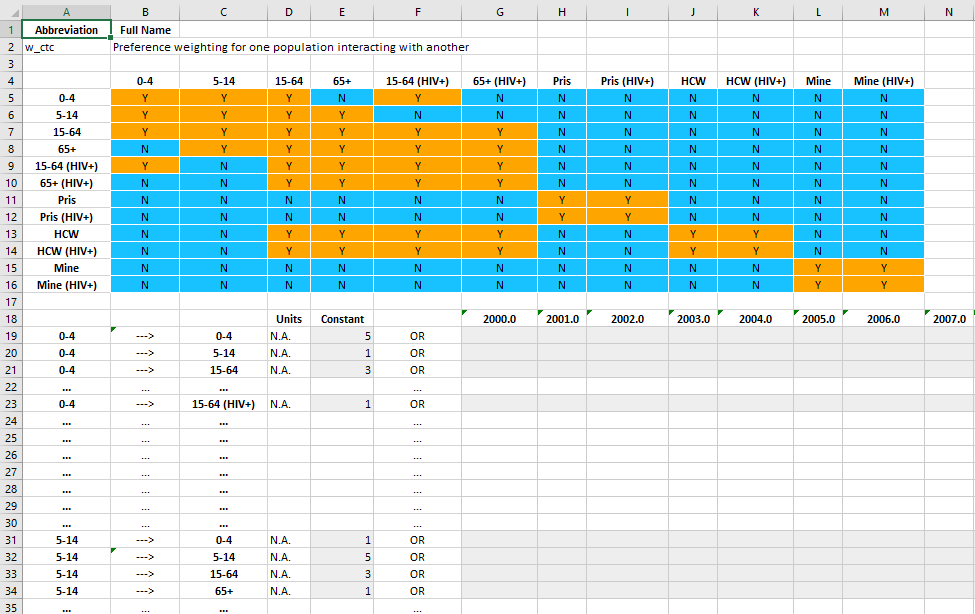

A `TimeDependentConnections` table consists of three elements

1. A code name/full name table at the top
2. A matrix of Y/N values that controls which time series appear on the page
3. A set of time series inputs where the user enters time-varying data

This table is managed by the `TimeDependentConnections` object in `excel.py` which has

- A code name
- A full name
- The type (whether it's an interaction or a transfer - the difference being, a transfer cannot have any entries on the diagonal i.e. within the same population)
- A list of population names
- A list of times
- A dict of `TimeSeries` objects keyed by the `(to,from)` populaton names
- A method `from_tables()` to construct a `TimeDependentConnections` instance based on the rows in the spreadsheet
- A method `write()` that takes in a sheet and a start row, and writes the content for the object to the spreadsheet

### TimeDependentValuesEntry

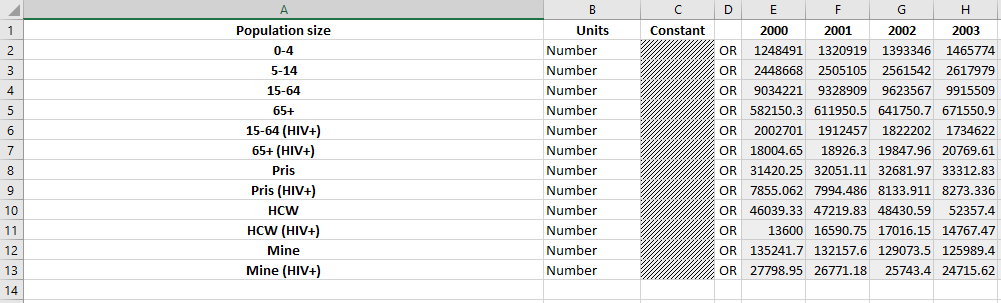

A `TimeDependentValuesEntry` consists of a single element with

- The full name of the quantity at the top left
- The left column with population names
- Value entry cells for contant and year-specific values

    A code name/full name table at the top
    A matrix of Y/N values that controls which time series appear on the page
    A set of time series inputs where the user enters time-varying data

This table is managed by the `TimeDependentValuesEntry` object in `excel.py` which has

- A name
- The time vector
- A dict of `TimeSeries` objects keyed by the population name
- A method `from_rows()` to construct a `TimeDependentValuesEntry` instance based on the rows in the spreadsheet
- A method `write()` that takes in a sheet and a start row, and writes the content for the object to the spreadsheet

## `ProjectData` operations

A number of possible operations can be performed on `ProjectData`

- Get a new instance using `ProjectData.new()` where you pass in a Framework together with a list (or number) or populations and transfers
- Use `to_spreadsheet()` to get an `AtomicaSpreadsheet` of the data, and `save()` to write the `ProjectData` to disk
- Use `get_ts()` to get the time-data associated with a quantity out of `ProjectData` e.g. when making parameters
- You can add or remove populations and transfers while keeping data intact
- You can change the time values using `change_tvec()` while keeping the data intact

Note that you can also change the time values in the spreadsheet in place just by adding or removing columns. In principle, you can also specify values only for a subset of populations, but at the moment this is probably not propagated through the model yet.